In [1]:
%config Completer.use_jedi = False
%matplotlib notebook
import astropy
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from astropy.table import Table
from astropy.io import fits
from glob import glob
import os
from tqdm import tqdm_notebook, tnrange, tqdm
#import pandas as pd
from astropy.wcs import WCS
import sys
from spectral_cube import SpectralCube
import fs
import fs.copy
import socket
import warnings

In [2]:
from RMtools_3D.do_RMsynth_3D import run_rmsynth, writefits as dirtywf, readFitsCube, readFreqFile
from RMtools_3D.do_RMclean_3D import writefits as cleanwf, run_rmclean
from RMutils.util_RM import do_rmclean_hogbom

In [3]:
import pymongo
client = pymongo.MongoClient()  # default connection (ie, local)

In [4]:
mydb = client['racs']  # Create/open database

In [5]:
mycol = mydb['spice']  # Create/open collection

In [6]:
document = mycol.find_one()
for k in document:
    print(k)

_id
header
island_id
island_name
n_components
ra_hms_cont
dec_dms_cont
ra_deg_cont
dec_deg_cont
freq
maj_axis
min_axis
pos_ang
flux_int
flux_int_err
flux_peak
mean_background
background_noise
max_residual
min_residual
mean_residual
rms_residual
stdev_residual
x_min
x_max
y_min
y_max
n_pix
solid_angle
beam_area
x_ave
y_ave
x_cen
y_cen
x_peak
y_peak
flag_i1
flag_i2
flag_i3
flag_i4
comment
i_file
q_file
u_file


In [7]:
# Basic querey
myquery = { "n_components": { "$lt": 2 } }

#mydoc = mycol.find(myquery, { "_id": 0, "island_name": 1, "flux_int": 1 , "n_components": 1})
mydoc = mycol.find(myquery).sort("flux_int", -1)
mydoc.count()
#for x in mydoc:
#    print(x['header']['BMAJ']*60*60, x['header']['BMIN']*60*60)

/home/athomson/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: count is deprecated. Use Collection.count_documents instead.
  


3482

# Get correct fluxes

In [2]:
sbid = 8585
field = 'RACS_test4_1.05_1049-31A'

# Check host and get file locations
host = socket.gethostname()

print('Host is',host)

if host == 'motley':
    rootdir= '/data/motley/athomson/cubes'
    warnings.warn("Data is on remote disk. Read/Write will be slow.")
    
if host[:6] == 'galaxy' or host[:4] == 'zeus':
    rootdir = '/group/askap/mcc381/RACS'
    warnings.warn("Data is on remote disk. Read/Write will be slow.")

if host[:6] == 'avatar':
    rootdir = '/avatar/athomson/cubes'
    
# Glob out the necessary files
cubes = glob(f'{rootdir}/{sbid}/{field}/image.restored.*contcube*linmos*fits') # Data cubes
#selavyfits = glob(f'{rootdir}/{sbid}/{field}/*.fits') # Selavy images
#voisle = glob(f'{rootdir}/{sbid}/{field}/*island*.xml') # Selvay VOTab
#vocomp = glob(f'{rootdir}/{sbid}/{field}/*components*.xml') # Selvay VOTab
#vores = glob(f'{rootdir}/{sbid}/{field}/*results*.xml') # Selvay VOTab


selavyfits = glob(f'{rootdir}/{sbid}/{field}/selavy*/comp*.fits') # Selavy images
voisle = glob(f'{rootdir}/{sbid}/{field}/selavy*/*island*.xml') # Selvay VOTab
vocomp = glob(f'{rootdir}/{sbid}/{field}/selavy*/*components*.xml') # Selvay VOTab
vores = glob(f'{rootdir}/{sbid}/{field}/selavy*/*results*.xml') # Selvay VOTab

print('Getting source-fiding results from:', voisle,'\n')
print('Getting spectral data from:', cubes, '\n')
print('Getting source location data from:', selavyfits, '\n')

# Get selvay data from VOTab
islands = Table.read(voisle[0], format='votable') 
components = Table.read(vocomp[0], format='votable') 
#selres = Table.read(vores[0], format='votable') 

Host is avatar29
Getting source-fiding results from: ['/avatar/athomson/cubes/8585/RACS_test4_1.05_1049-31A/selavy-cont-image.i.SB8583.cont.RACS_test4_1.05_1049-31A.linmos.taylor.0.restored/selavy-image.i.SB8583.cont.RACS_test4_1.05_1049-31A.linmos.taylor.0.restored.islands.xml'] 

Getting spectral data from: ['/avatar/athomson/cubes/8585/RACS_test4_1.05_1049-31A/image.restored.i.SB8583.contcube.RACS_test4_1.05_1049-31A.linmos.fits', '/avatar/athomson/cubes/8585/RACS_test4_1.05_1049-31A/image.restored.q.SB8583.contcube.RACS_test4_1.05_1049-31A.linmos.fits', '/avatar/athomson/cubes/8585/RACS_test4_1.05_1049-31A/image.restored.u.SB8583.contcube.RACS_test4_1.05_1049-31A.linmos.fits'] 

Getting source location data from: ['/avatar/athomson/cubes/8585/RACS_test4_1.05_1049-31A/selavy-cont-image.i.SB8583.cont.RACS_test4_1.05_1049-31A.linmos.taylor.0.restored/componentMap_image.i.SB8583.cont.RACS_test4_1.05_1049-31A.linmos.taylor.0.restored.fits', '/avatar/athomson/cubes/8585/RACS_test4_1.05_1

In [11]:
loners = components[components['col_has_siblings']==0]
loners.add_index('col_island_id')

In [33]:
#myquery = { "island_id":  loners['col_island_id'][0] }
fields = ['col_flux_peak', 'col_flux_peak_err', 'col_flux_int', 'col_flux_int_err']
for i in tnrange(len(loners)):
    myquery = { '$and': [ { 'n_components': { '$lt': 2 } }, \
                       { "island_id":  loners['col_island_id'][i] } ] }
    #myquery = { "n_components": 1  }
    #newvalues = { "$set": { "flux_int_comp": "Minnie" } }
    #mydoc = mycol.find(myquery)
    #for x in mydoc:
    #    print(x['island_id'])
    for field in fields:
        newvalues = { "$set": { field.replace('col','comp'):  float(loners[field][i])} }
        mycol.update_one(myquery, newvalues)

In [55]:
# Basic querey
myquery = { "n_components": { "$lt": 2 } }
#myquery = {}
#mydoc = mycol.find(myquery, { "_id": 0, "island_name": 1, "flux_int": 1 , "n_components": 1})
mydoc = mycol.find(myquery).sort("comp_flux_int", -1)
#mydoc = mycol.find()
mydoc.count()
f_peak = []
f_int = []
noise = []
for x in mydoc:
    try:
        f_peak.append(x['comp_flux_peak'])
        noise.append(x['background_noise'])
        f_int.append(x['comp_flux_int'])
    except:
        print('cont')
        continue
f_peak = np.array(f_peak)
noise = np.array(noise)
f_int = np.array(f_int)


cont


/home/athomson/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: count is deprecated. Use Collection.count_documents instead.
  import sys


In [57]:
from matplotlib.colors import LogNorm()

SyntaxError: invalid syntax (<ipython-input-57-f2cd69ef0c06>, line 1)

<IPython.core.display.Javascript object>


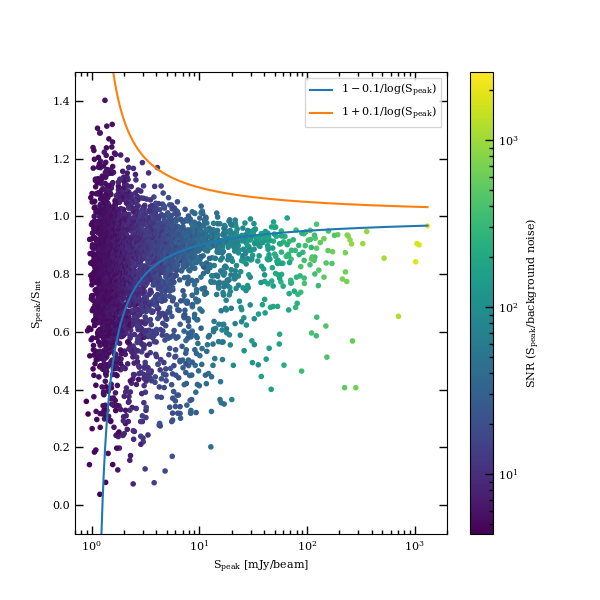

/home/athomson/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/home/athomson/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide


In [62]:
snr = f_peak/noise
plt.figure()
plt.scatter(f_peak, f_peak/(f_int), c=snr, marker='.', norm=LogNorm())
cbar = plt.colorbar()
cbar.set_label('SNR ($S_{peak}$/background noise)')
plt.xscale('log')
plt.xlabel(r'S$_{peak}$ [mJy/beam]')
plt.ylabel(r'S$_{peak}$/S$_{int}$')

x = np.linspace(1e0, f_peak.max(), num=100000)
y = 1 - (0.1/np.log10(x))

plt.plot(x, y, label='$1 - 0.1/log(S_{peak})$')


x = np.linspace(1e0, f_peak.max(), num=100000)
y = 1 + (0.1/np.log10(x))

plt.plot(x, y, label='$1 + 0.1/log(S_{peak})$')
plt.ylim(-0.1,1.5)
plt.xlim(7e-1, 2e3)

plt.legend()

In [68]:
# Basic querey
myquery = { "n_components": { "$lt": 2 } }
mydoc = mycol.find(myquery)
#print(mydoc.count())
for item in tqdm_notebook(mydoc):
    try:
        s_peak = item['comp_flux_peak']
        s_int  = item['comp_flux_int']
        m_id = item['_id']
        test = 1 - (0.1 / np.log10(s_peak))
        frac = s_peak / s_int
        query = { "_id": m_id }
        if frac < test:
            newvalues = { "$set": { 'resolved':  True } }
            mycol.update_one(query, newvalues)
        else: 
            newvalues = { "$set": { 'resolved':  False } }
            mycol.update_one(query, newvalues)
    except:
        continue

# Make tests for CASDA

In [8]:
import warnings
warnings.filterwarnings("ignore")

In [30]:
import schwimmbad
from multiprocessing import cpu_count
import shlex, subprocess

In [32]:
n_cores = 28 # Use all available cores
use_mpi = False # Use or not with Schwimmbad

outdir = '/avatar/athomson/cubes/8585/RACS_test4_1.05_1049-31A/testcuts'
try:
    os.mkdir(outdir)
except:
    print('Directory exists')
for i in tnrange(10):
    # Copy I
    command_line = f"cp {mydoc[i]['i_file']} {outdir}/"
    args = shlex.split(command_line)
    out = subprocess.run(args, capture_output=True)
    print(out.stderr, out.stdout)
    # Copy Q
    command_line = f"cp {mydoc[i]['q_file']} {outdir}/"
    args = shlex.split(command_line)
    out = subprocess.run(args, capture_output=True)
    print(out.stderr, out.stdout)
    # Copy U
    command_line = f"cp {mydoc[i]['u_file']} {outdir}/"
    args = shlex.split(command_line)
    out = subprocess.run(args, capture_output=True)
    print(out.stderr, out.stdout)
    
    idata = SpectralCube.read(mydoc[i]["i_file"], mode='denywrite')
    qdata = SpectralCube.read(mydoc[i]["q_file"], mode='denywrite')
    udata = SpectralCube.read(mydoc[i]["u_file"], mode='denywrite')
    
    head = idata.header
    
    freqfile = f"{outdir}/frequencies.txt"
    freq = np.loadtxt(freqfile)
    
    dataArr = run_rmsynth(qdata.hdu.data, 
                          udata.hdu.data, 
                          freq, 
                          verbose=False, 
                          nSamples=5
                         )
    preout = f"{mydoc[i]['island_name']}."
    dirtywf(dataArr, 
              head, 
              prefixOut=preout,
              outDir=outdir,
              not_rmsf=False,
              verbose=False,
            write_seperate_FDF=True
             )
    
    FDFcube, phiArr_radm2, RMSFcube, phi2Arr_radm2, \
        fwhmRMSFCube,fitStatArr, lam0Sq_m2, lambdaSqArr_m2 = dataArr
    with schwimmbad.choose_pool(mpi=use_mpi, processes=n_cores) as pool:
        fitsFDF = f"{outdir}/{preout}FDF_im_dirty.fits"
        fitsRMSF = f"{outdir}/{preout}RMSF_im.fits"
        cleanFDF, ccArr, iterCountArr, residFDF, head \
                = run_rmclean(fitsFDF,
                            fitsRMSF,
                            0.01,
                            maxIter=1000,
                            gain=0.1,
                            nBits=32,
                            pool=pool,
                            chunksize=None,
                            verbose=False,
                        )
        
    cleanwf(cleanFDF,
            ccArr,
            iterCountArr,
            residFDF,
            head,
            prefixOut=preout,
            outDir=outdir,
            write_separate_FDF=True,
            verbose=False
           )

Directory exists


b'' b''
b'' b''
b'' b''
b'' b''
b'' b''
b'' b''
b'' b''
b'' b''
b'' b''
b'' b''
b'' b''
b'' b''
b'' b''
b'' b''
b'' b''
b'' b''
b'' b''
b'' b''
b'' b''
b'' b''
b'' b''
b'' b''
b'' b''
b'' b''
b'' b''
b'' b''
b'' b''
b'' b''
b'' b''
b'' b''



In [33]:
from astropy.table import Table

In [34]:
ras = []
decs = []
names = []
cols = ['ra_deg_cont', 'dec_deg_cont', 'island_name']
for i in tnrange(10):
    ras.append(mydoc[i][cols[0]])
    decs.append(mydoc[i][cols[1]])
    names.append(mydoc[i][cols[2]])

In [35]:
t = Table([ras,decs,names], names=cols)

In [36]:
t

<Table length=10>
ra_deg_cont dec_deg_cont  island_name  
  float64     float64        str14     
----------- ------------ --------------
 159.316835   -29.567359 J103716-293402
 162.769628   -31.637289 J105104-313814
 159.348867   -29.131603 J103723-290753
 161.419004   -29.457327 J104540-292726
 165.278243   -31.674406 J110106-314027
 165.578604   -31.045879 J110218-310245
 160.730161    -28.82157 J104255-284917
 165.500406   -31.231526 J110200-311353
 161.148744   -28.691332 J104435-284128
 159.426744   -28.384398 J103742-282303

In [37]:
t.write(f'{outdir}/spice_test.xml', format='votable')

In [43]:
i = 0
command_line = f"rmsynth3d {qtestfiles[i]} {utestfiles[i]} {freqfile}"
args = shlex.split(command_line)
subprocess.run(args, capture_output=True)

CompletedProcess(args=['rmsynth3d', '/avatar/athomson/cubes/8585/RACS_test4_1.05_1049-31A/testcuts/image.restored.q.SB.8585.contcube.RACS_test4_1.05_1049-31A.cutout.J103716-293402.fits', '/avatar/athomson/cubes/8585/RACS_test4_1.05_1049-31A/testcuts/image.restored.u.SB.8585.contcube.RACS_test4_1.05_1049-31A.cutout.J103716-293402.fits', '/avatar/athomson/cubes/8585/RACS_test4_1.05_1049-31A/testcuts/frequencies.txt'], returncode=0, stdout=b'', stderr=b'')

# First look

In [14]:
def getfrac(i):
    idata = SpectralCube.read(mydoc[i]["i_file"], mode='denywrite')
    qdata = SpectralCube.read(mydoc[i]["q_file"], mode='denywrite')
    udata = SpectralCube.read(mydoc[i]["u_file"], mode='denywrite')
    pdata = (qdata**2 + udata**2)**0.5
    im_av = idata[0]
    ind = np.unravel_index(im_av.argmax(), im_av.shape)
    frac = pdata/idata*100
    #print(f'Polarzation fraction is {frac[:,ind[0], ind[1]][0]:.2f}% at {freq[0]/1e6:.1f}GHz')
    return frac[:,ind[0], ind[1]][0]

In [15]:
def getsnr(i):
    sig = mydoc[i]["flux_int"]
    noise = mydoc[i]["background_noise"]
    snr = sig/noise
    return snr

In [16]:
n_cores = cpu_count() # Use all available cores
use_mpi = False # Use or not with Schwimmbad

In [26]:
# Use Schwimmbad to write all cutouts to disk in parallel
with schwimmbad.choose_pool(mpi=use_mpi, processes=n_cores) as pool:
    if use_mpi:
        pool.map(getfrac, [i for i in range(mydoc.count())])
    else:
        fracs=list(tqdm_notebook(pool.imap_unordered(getfrac, 
                                          [i for i in range(mydoc.count())]),
                     total = mydoc.count()
                     ))
        snrs=list(tqdm_notebook(pool.imap_unordered(getsnr, 
                                          [i for i in range(mydoc.count())]),
                     total = mydoc.count()
                     ))
fracs = np.array(fracs)
snrs = np.array(snrs)

In [20]:
fracs.shape

(3482,)

<IPython.core.display.Javascript object>


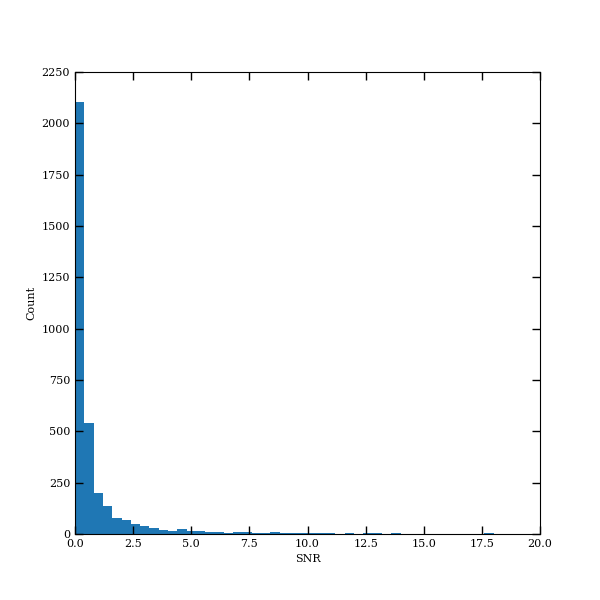

Text(0, 0.5, 'Count')

In [27]:
plt.figure()
plt.hist(snrs, bins=50, range=(0,20))
plt.xlabel('SNR')
plt.ylabel('Count')

<IPython.core.display.Javascript object>


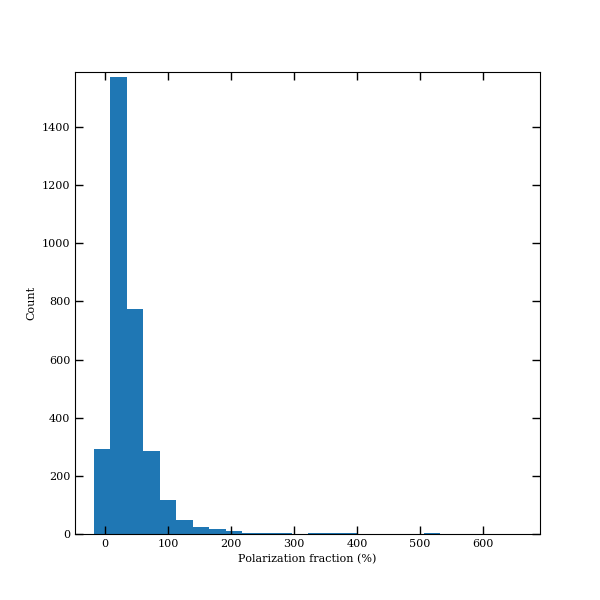

Text(0, 0.5, 'Count')

In [31]:
plt.figure()
plt.hist(fracs, bins=250, log=False)
plt.xlabel('Polarization fraction (%)')
plt.ylabel('Count')

In [68]:
len(fracs[snrs>1])

720

<IPython.core.display.Javascript object>


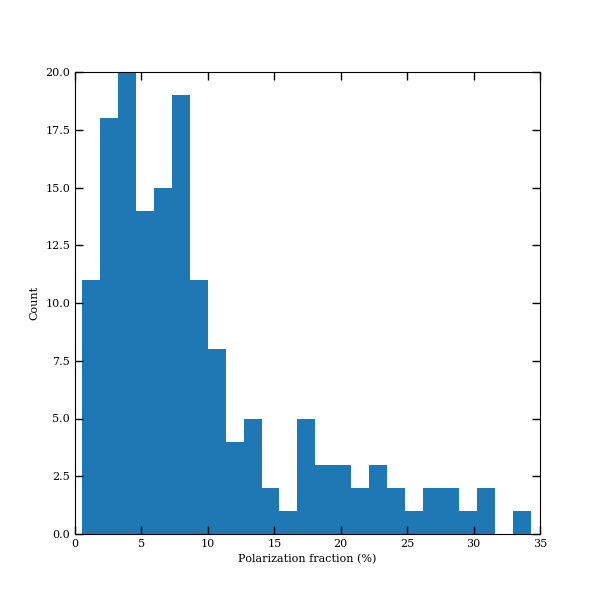

Text(0, 0.5, 'Count')

In [22]:
plt.figure()
plt.hist(fracs[snrs>5], bins=25)
plt.xlabel('Polarization fraction (%)')
plt.ylabel('Count')

In [32]:
def makeplots(i):
    idata = SpectralCube.read(mydoc[i]["i_file"], mode='denywrite')
    qdata = SpectralCube.read(mydoc[i]["q_file"], mode='denywrite')
    udata = SpectralCube.read(mydoc[i]["u_file"], mode='denywrite')
    pdata = (qdata**2 + udata**2)**0.5
    freq = idata.spectral_axis
    im_av = idata.sum(axis=0)
    im_av.quicklook()
    fig = plt.gcf()
    ax = plt.gca()
    fig.suptitle('SUM(I) - STOKES I')
    fig.set_figheight(4)
    fig.set_figwidth(4)

    idata[0].quicklook()
    fig = plt.gcf()
    ax = plt.gca()
    fig.suptitle('STOKES I')
    fig.set_figheight(4)
    fig.set_figwidth(4)

    qdata[0].quicklook()
    fig = plt.gcf()
    ax = plt.gca()
    fig.suptitle('STOKES Q')
    fig.set_figheight(4)
    fig.set_figwidth(4)

    udata[0].quicklook()
    fig = plt.gcf()
    ax = plt.gca()
    fig.suptitle('STOKES U')
    fig.set_figheight(4)
    fig.set_figwidth(4)

    pdata[0].quicklook()
    fig = plt.gcf()
    ax = plt.gca()
    fig.suptitle('PI')
    fig.set_figheight(4)
    fig.set_figwidth(4)
    ind = np.unravel_index(np.argmax(im_av, axis=None), im_av.shape)
    print(ind)
    plt.plot(ind[1],ind[0], 'r+')
    
    plt.figure()
    plt.plot(freq/1e6, idata[:,ind[0], ind[1]], 'k', label='I')
    plt.plot(freq/1e6, qdata[:,ind[0], ind[1]], 'tab:red', label='Q')
    plt.plot(freq/1e6, udata[:,ind[0], ind[1]], 'tab:blue', label='U')
    plt.legend()
    plt.xlabel('Frequency (MHz)')
    plt.ylabel('Flux (Jy/beam)')
    #FDFcube, phiArr_radm2, lam0Sq_m2, lambdaSqArr_m2 = run_rmsynth(qdata,
    #                                                               udata,
    #                                                               freq,
    #                                                               phiMax_radm2=1000,
    #                                                               not_rmsf=True,
    #                                                               verbose=True,
    #                                                              )
    #plt.figure()
    #plt.imshow(np.abs(FDFcube).sum(axis=0), origin='lower', cmap='magma')
    #plt.contour(im_av, origin='lower', colors='w', alpha=0.1)
    #plt.title('SUM(ABS(FDF)) -- PI')
    #frac = pdata/idata*100
    #print(f'Polarzation fraction is {frac[0,ind[0], ind[1]]:.2f}% at {freq[0]/1e6:.1f}GHz')
#
    #peak_pi_idx = np.argmax(FDFcube, axis=0)
    #plt.figure()
    #plt.title('Peak PI')
    #plt.imshow(phiArr_radm2[peak_pi], cmap='RdBu_r', origin='lower')
    #plt.colorbar()
    #plt.contour(np.abs(FDFcube).sum(axis=0), origin='lower', colors='k', alpha=0.1)

<IPython.core.display.Javascript object>


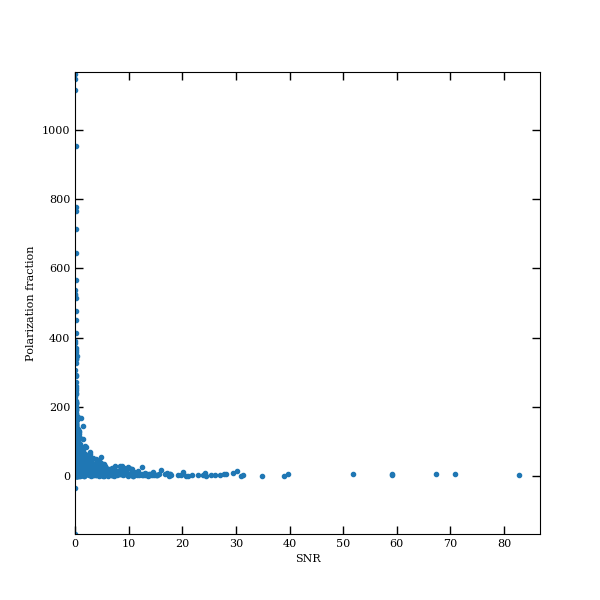

Text(0, 0.5, 'Polarization fraction')

In [24]:
plt.figure()
plt.plot(snrs, fracs, '.')
#plt.plot([1, 90], [5,5], 'r')
#plt.xscale('log')
#plt.yscale('log')
plt.xlabel('SNR')
plt.ylabel('Polarization fraction')

In [26]:
np.sqrt(len(snrs[snrs>5]))

13.0

In [27]:
enumerate(np.where(snrs>5)[0])

In [ ]:
%matplotlib inline

<IPython.core.display.Javascript object>


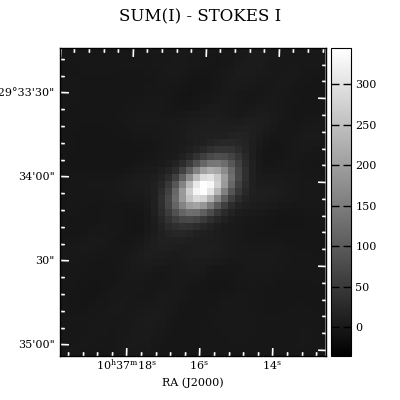

INFO: Auto-setting vmin to -3.531e+01 [aplpy.core]
INFO: Auto-setting vmax to  3.446e+02 [aplpy.core]


<IPython.core.display.Javascript object>


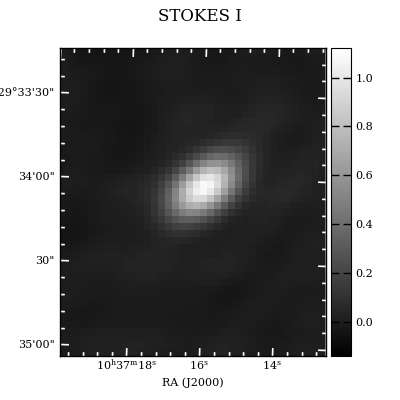

INFO: Auto-setting vmin to -1.400e-01 [aplpy.core]
INFO: Auto-setting vmax to  1.121e+00 [aplpy.core]


<IPython.core.display.Javascript object>


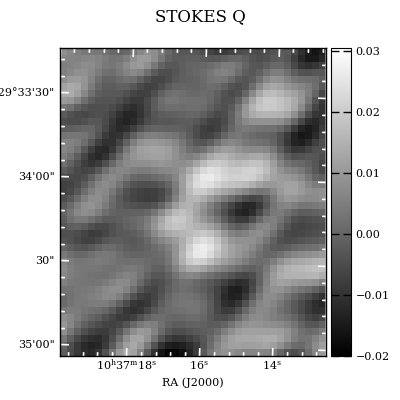

INFO: Auto-setting vmin to -2.007e-02 [aplpy.core]
INFO: Auto-setting vmax to  3.052e-02 [aplpy.core]


<IPython.core.display.Javascript object>


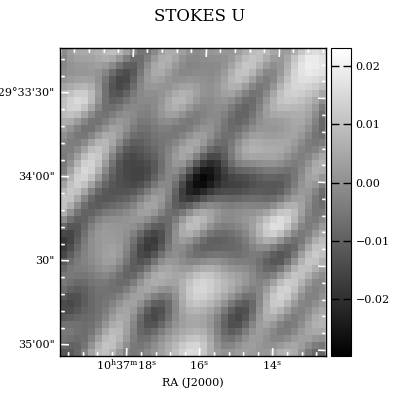

INFO: Auto-setting vmin to -2.977e-02 [aplpy.core]
INFO: Auto-setting vmax to  2.313e-02 [aplpy.core]


<IPython.core.display.Javascript object>


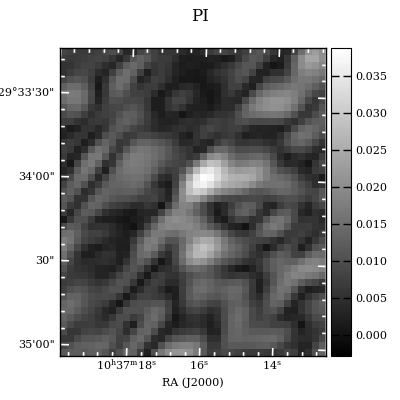

INFO: Auto-setting vmin to -2.852e-03 [aplpy.core]
INFO: Auto-setting vmax to  3.879e-02 [aplpy.core]
(24, 20)


<IPython.core.display.Javascript object>


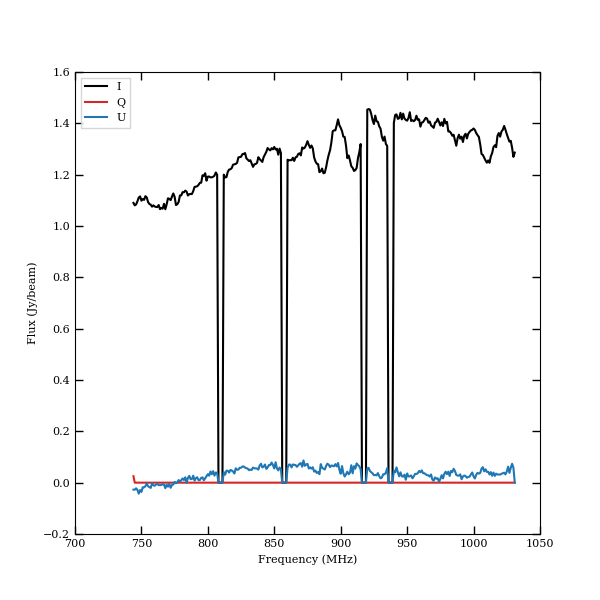

<IPython.core.display.Javascript object>


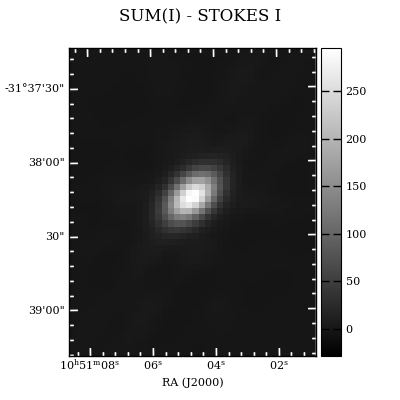

INFO: Auto-setting vmin to -2.858e+01 [aplpy.core]
INFO: Auto-setting vmax to  2.951e+02 [aplpy.core]


<IPython.core.display.Javascript object>


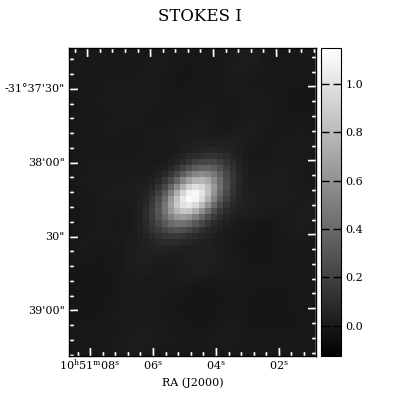

INFO: Auto-setting vmin to -1.238e-01 [aplpy.core]
INFO: Auto-setting vmax to  1.147e+00 [aplpy.core]


<IPython.core.display.Javascript object>


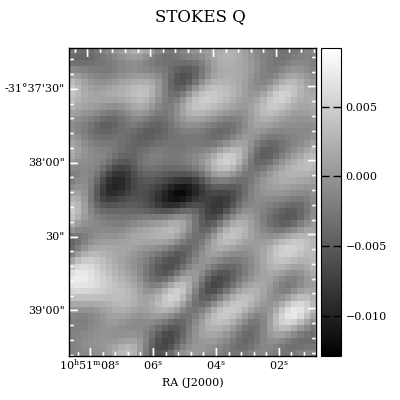

INFO: Auto-setting vmin to -1.289e-02 [aplpy.core]
INFO: Auto-setting vmax to  9.213e-03 [aplpy.core]


<IPython.core.display.Javascript object>


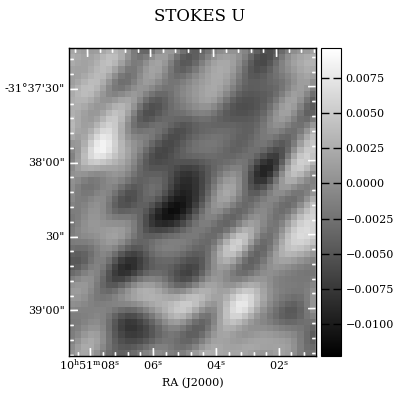

INFO: Auto-setting vmin to -1.226e-02 [aplpy.core]
INFO: Auto-setting vmax to  9.608e-03 [aplpy.core]


<IPython.core.display.Javascript object>


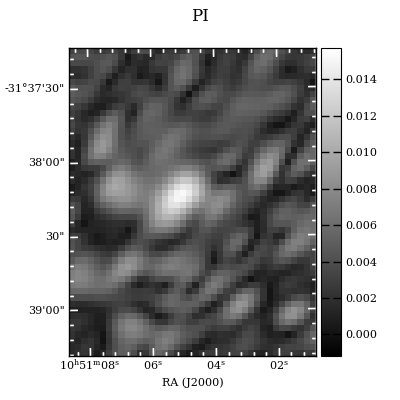

INFO: Auto-setting vmin to -1.179e-03 [aplpy.core]
INFO: Auto-setting vmax to  1.570e-02 [aplpy.core]
(25, 19)


<IPython.core.display.Javascript object>


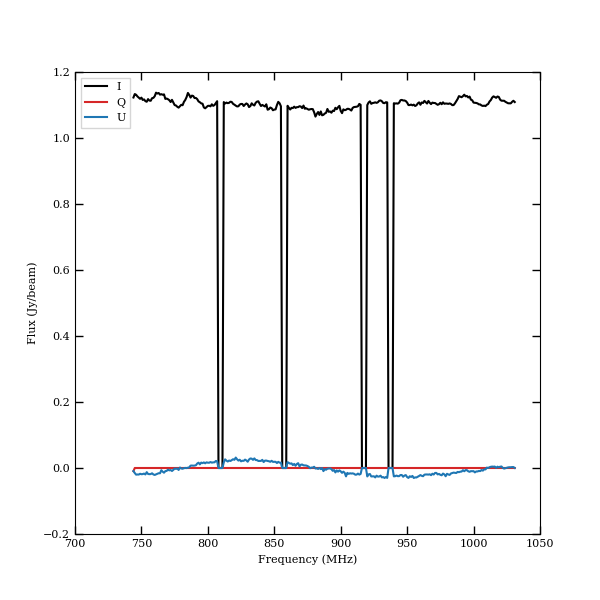

<IPython.core.display.Javascript object>


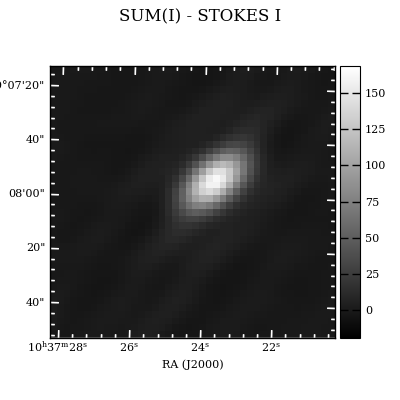

INFO: Auto-setting vmin to -1.916e+01 [aplpy.core]
INFO: Auto-setting vmax to  1.685e+02 [aplpy.core]


<IPython.core.display.Javascript object>


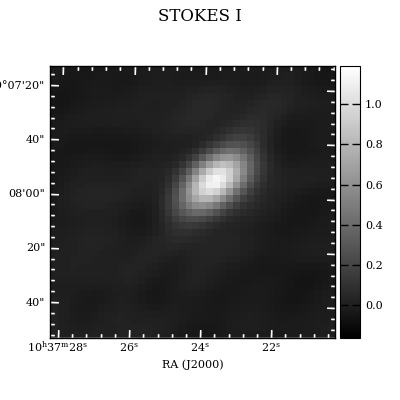

INFO: Auto-setting vmin to -1.616e-01 [aplpy.core]
INFO: Auto-setting vmax to  1.189e+00 [aplpy.core]


<IPython.core.display.Javascript object>


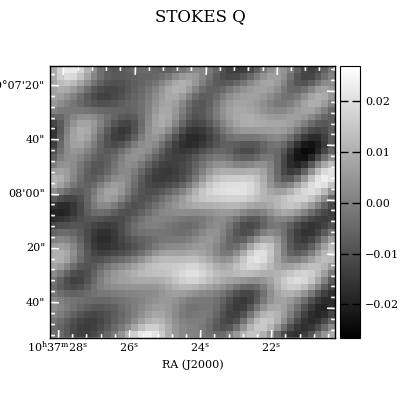

INFO: Auto-setting vmin to -2.653e-02 [aplpy.core]
INFO: Auto-setting vmax to  2.685e-02 [aplpy.core]


<IPython.core.display.Javascript object>


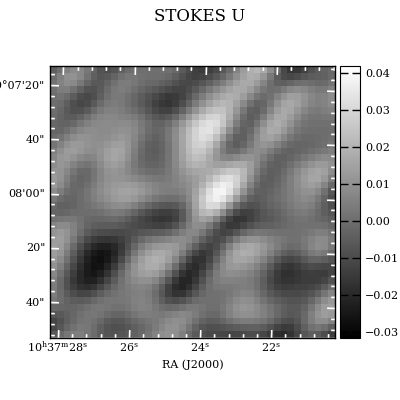

INFO: Auto-setting vmin to -3.148e-02 [aplpy.core]
INFO: Auto-setting vmax to  4.194e-02 [aplpy.core]


<IPython.core.display.Javascript object>


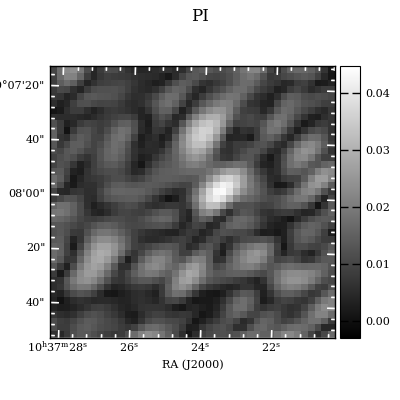

INFO: Auto-setting vmin to -3.008e-03 [aplpy.core]
INFO: Auto-setting vmax to  4.474e-02 [aplpy.core]
(23, 24)


<IPython.core.display.Javascript object>


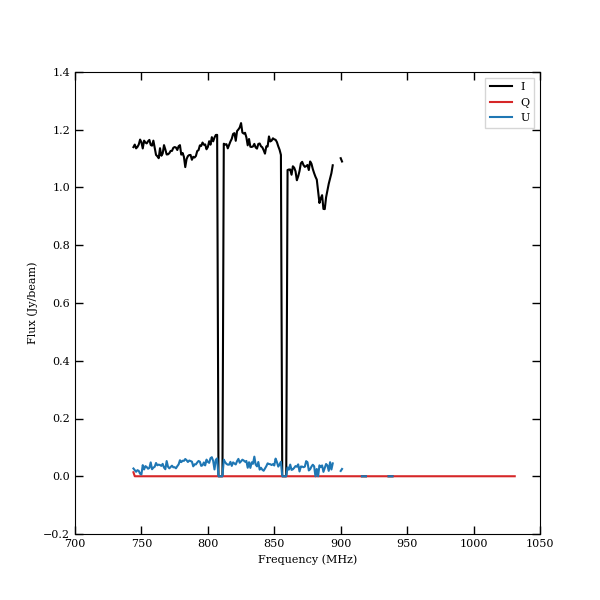

<IPython.core.display.Javascript object>


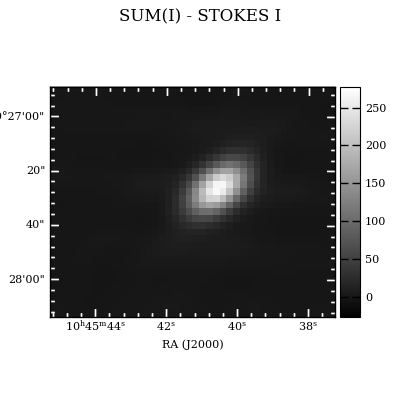

INFO: Auto-setting vmin to -2.742e+01 [aplpy.core]
INFO: Auto-setting vmax to  2.777e+02 [aplpy.core]


<IPython.core.display.Javascript object>


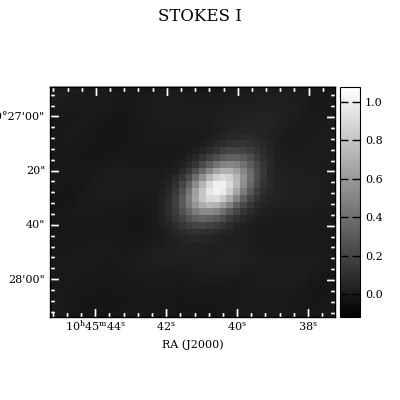

INFO: Auto-setting vmin to -1.217e-01 [aplpy.core]
INFO: Auto-setting vmax to  1.081e+00 [aplpy.core]


<IPython.core.display.Javascript object>


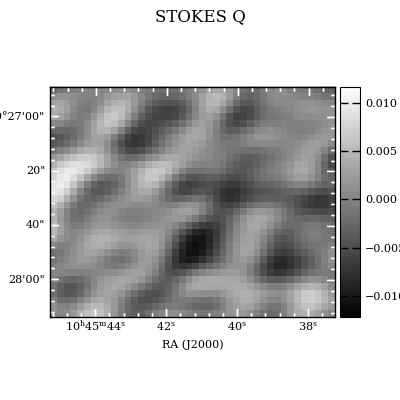

INFO: Auto-setting vmin to -1.223e-02 [aplpy.core]
INFO: Auto-setting vmax to  1.166e-02 [aplpy.core]


<IPython.core.display.Javascript object>


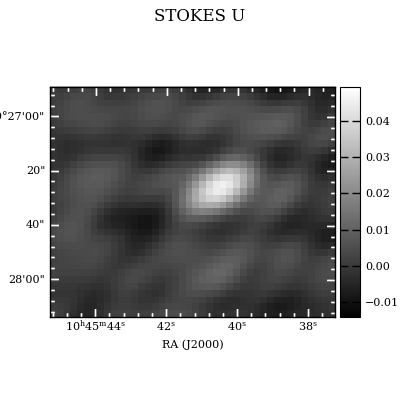

INFO: Auto-setting vmin to -1.416e-02 [aplpy.core]
INFO: Auto-setting vmax to  4.945e-02 [aplpy.core]


<IPython.core.display.Javascript object>


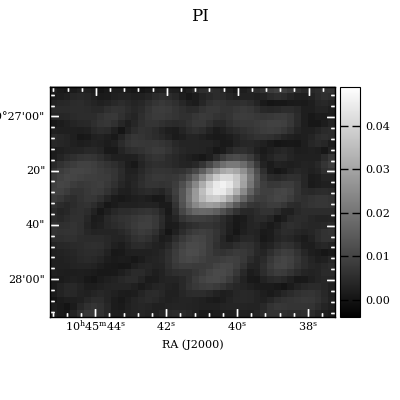

INFO: Auto-setting vmin to -4.042e-03 [aplpy.core]
INFO: Auto-setting vmax to  4.900e-02 [aplpy.core]
(18, 24)


<IPython.core.display.Javascript object>


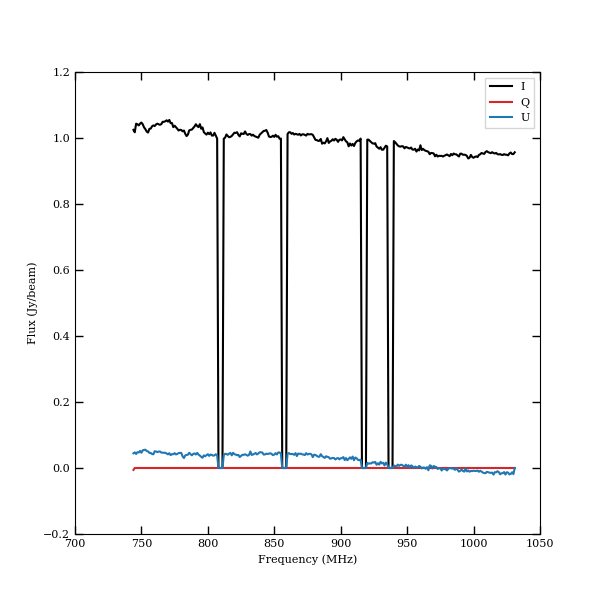

<IPython.core.display.Javascript object>


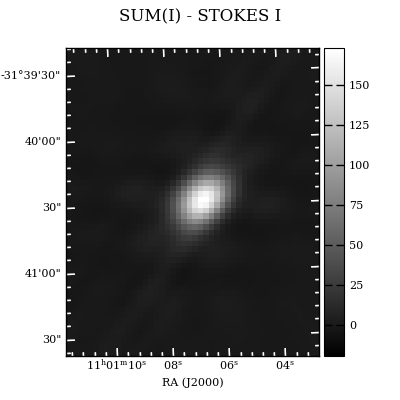

INFO: Auto-setting vmin to -1.905e+01 [aplpy.core]
INFO: Auto-setting vmax to  1.732e+02 [aplpy.core]


<IPython.core.display.Javascript object>


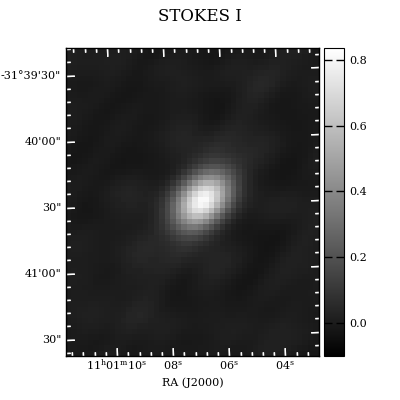

INFO: Auto-setting vmin to -1.017e-01 [aplpy.core]
INFO: Auto-setting vmax to  8.375e-01 [aplpy.core]


<IPython.core.display.Javascript object>


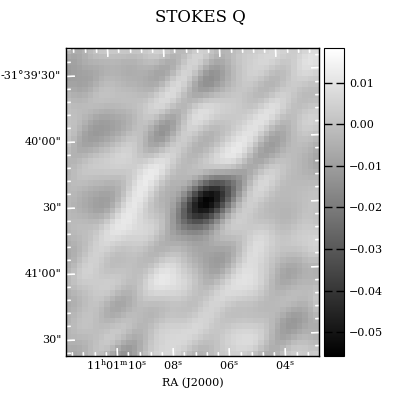

INFO: Auto-setting vmin to -5.576e-02 [aplpy.core]
INFO: Auto-setting vmax to  1.838e-02 [aplpy.core]


<IPython.core.display.Javascript object>


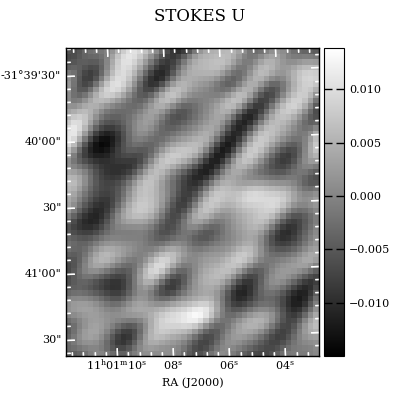

INFO: Auto-setting vmin to -1.496e-02 [aplpy.core]
INFO: Auto-setting vmax to  1.384e-02 [aplpy.core]


<IPython.core.display.Javascript object>


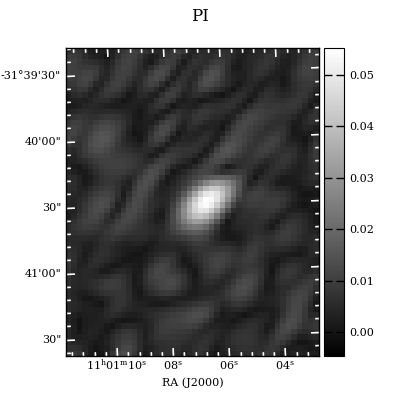

INFO: Auto-setting vmin to -4.642e-03 [aplpy.core]
INFO: Auto-setting vmax to  5.517e-02 [aplpy.core]
(28, 25)


<IPython.core.display.Javascript object>


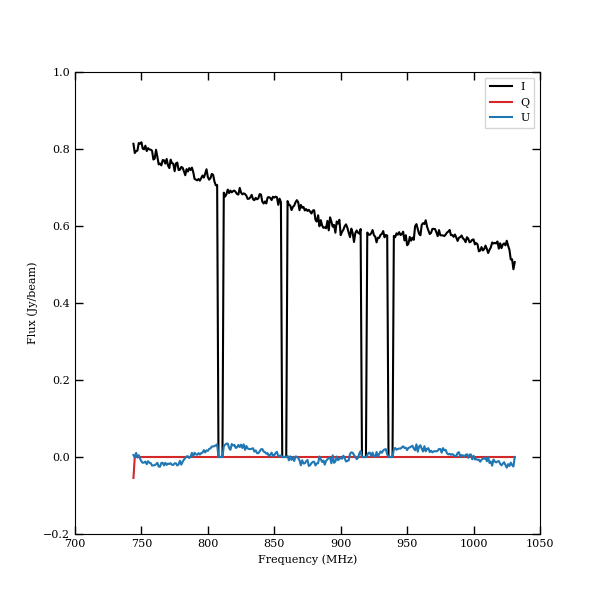

<IPython.core.display.Javascript object>


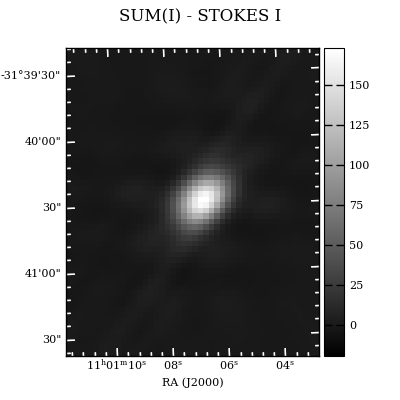

INFO: Auto-setting vmin to -1.905e+01 [aplpy.core]
INFO: Auto-setting vmax to  1.732e+02 [aplpy.core]


<IPython.core.display.Javascript object>


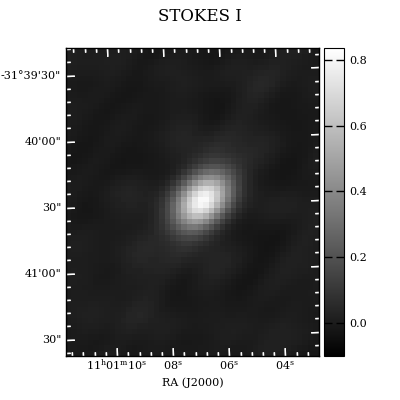

INFO: Auto-setting vmin to -1.017e-01 [aplpy.core]
INFO: Auto-setting vmax to  8.375e-01 [aplpy.core]


<IPython.core.display.Javascript object>


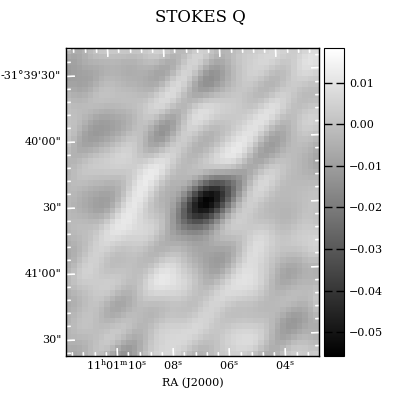

INFO: Auto-setting vmin to -5.576e-02 [aplpy.core]
INFO: Auto-setting vmax to  1.838e-02 [aplpy.core]


<IPython.core.display.Javascript object>


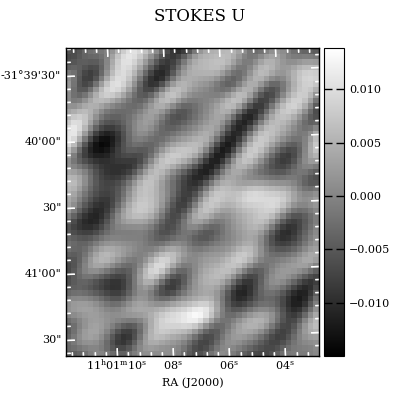

INFO: Auto-setting vmin to -1.496e-02 [aplpy.core]
INFO: Auto-setting vmax to  1.384e-02 [aplpy.core]


<IPython.core.display.Javascript object>


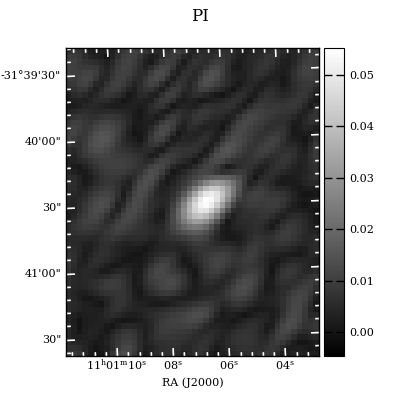

INFO: Auto-setting vmin to -4.642e-03 [aplpy.core]
INFO: Auto-setting vmax to  5.517e-02 [aplpy.core]
(28, 25)


<IPython.core.display.Javascript object>


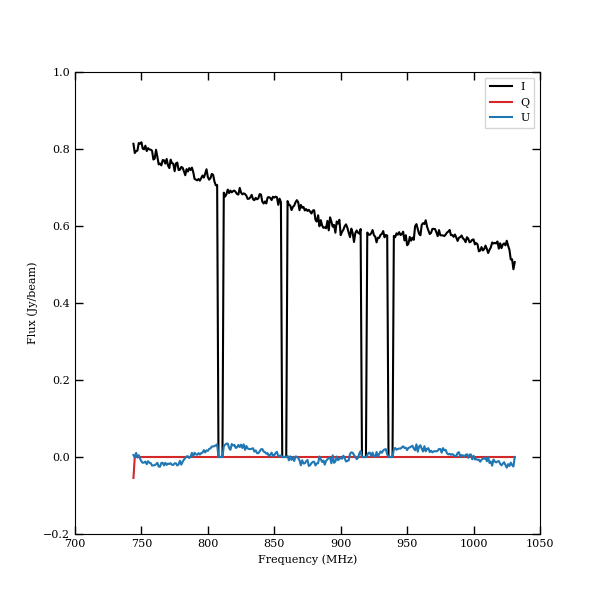

<IPython.core.display.Javascript object>


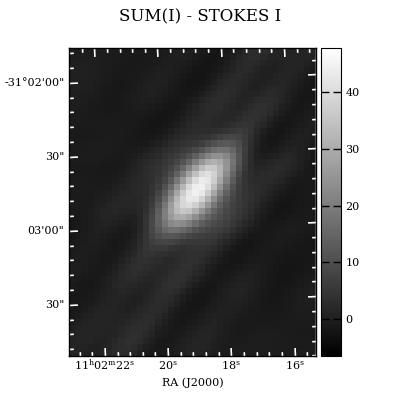

INFO: Auto-setting vmin to -6.512e+00 [aplpy.core]
INFO: Auto-setting vmax to  4.782e+01 [aplpy.core]


<IPython.core.display.Javascript object>


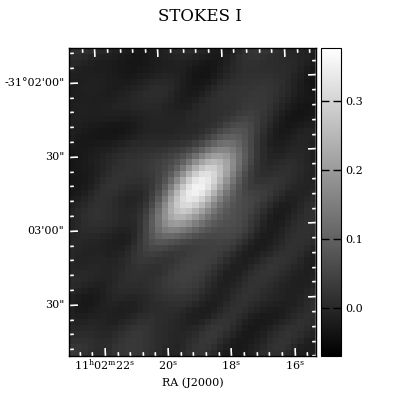

INFO: Auto-setting vmin to -6.932e-02 [aplpy.core]
INFO: Auto-setting vmax to  3.774e-01 [aplpy.core]


<IPython.core.display.Javascript object>


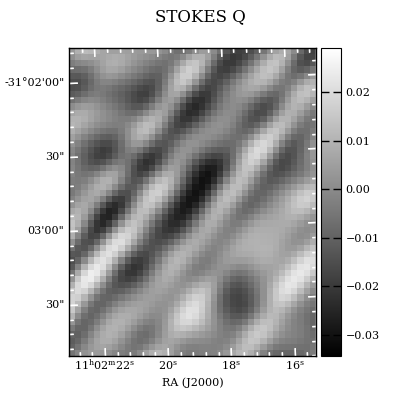

INFO: Auto-setting vmin to -3.439e-02 [aplpy.core]
INFO: Auto-setting vmax to  2.913e-02 [aplpy.core]


<IPython.core.display.Javascript object>


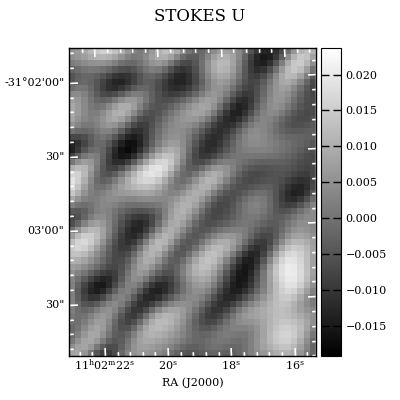

INFO: Auto-setting vmin to -1.920e-02 [aplpy.core]
INFO: Auto-setting vmax to  2.369e-02 [aplpy.core]


<IPython.core.display.Javascript object>


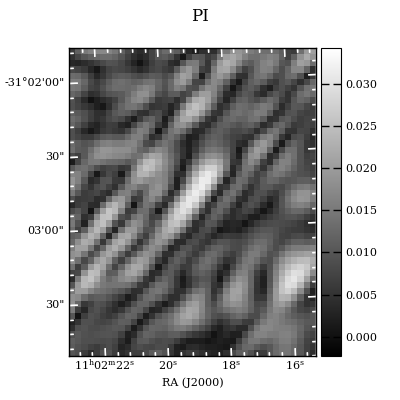

INFO: Auto-setting vmin to -2.258e-03 [aplpy.core]
INFO: Auto-setting vmax to  3.421e-02 [aplpy.core]
(27, 21)


<IPython.core.display.Javascript object>


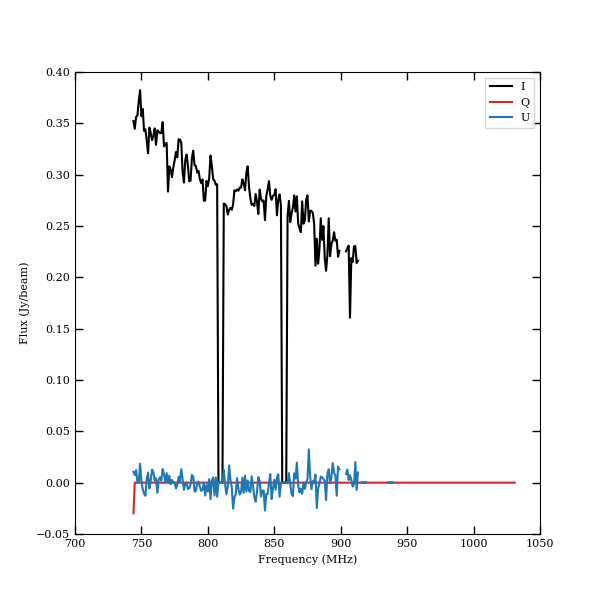

<IPython.core.display.Javascript object>


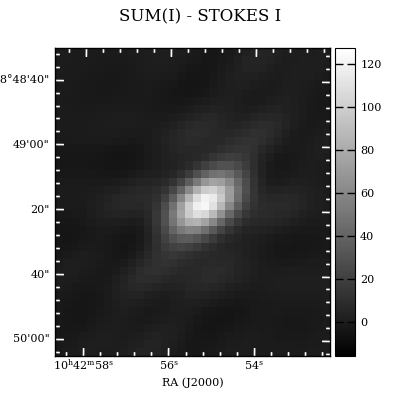

INFO: Auto-setting vmin to -1.570e+01 [aplpy.core]
INFO: Auto-setting vmax to  1.272e+02 [aplpy.core]


<IPython.core.display.Javascript object>


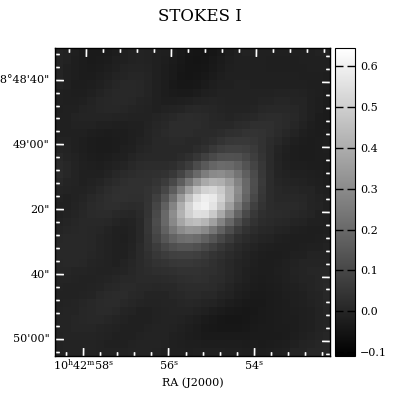

INFO: Auto-setting vmin to -1.100e-01 [aplpy.core]
INFO: Auto-setting vmax to  6.452e-01 [aplpy.core]


<IPython.core.display.Javascript object>


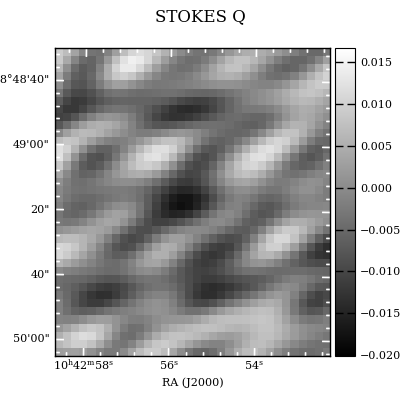

INFO: Auto-setting vmin to -2.010e-02 [aplpy.core]
INFO: Auto-setting vmax to  1.671e-02 [aplpy.core]


<IPython.core.display.Javascript object>


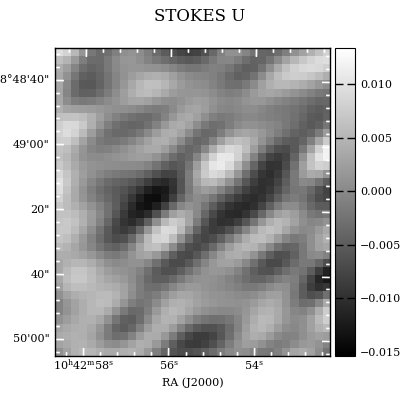

INFO: Auto-setting vmin to -1.538e-02 [aplpy.core]
INFO: Auto-setting vmax to  1.339e-02 [aplpy.core]


<IPython.core.display.Javascript object>


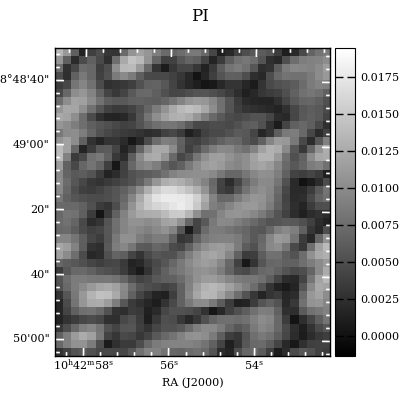

INFO: Auto-setting vmin to -1.383e-03 [aplpy.core]
INFO: Auto-setting vmax to  1.947e-02 [aplpy.core]
(18, 18)


<IPython.core.display.Javascript object>


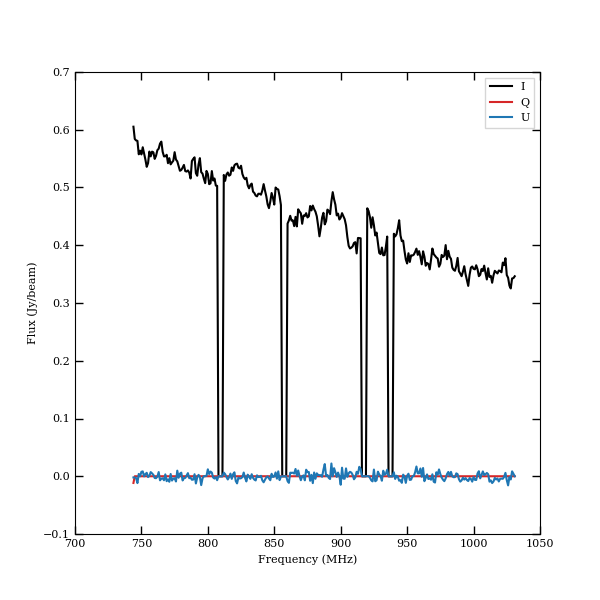

<IPython.core.display.Javascript object>


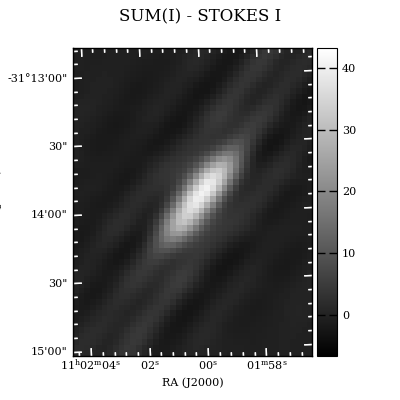

INFO: Auto-setting vmin to -6.737e+00 [aplpy.core]
INFO: Auto-setting vmax to  4.329e+01 [aplpy.core]


<IPython.core.display.Javascript object>


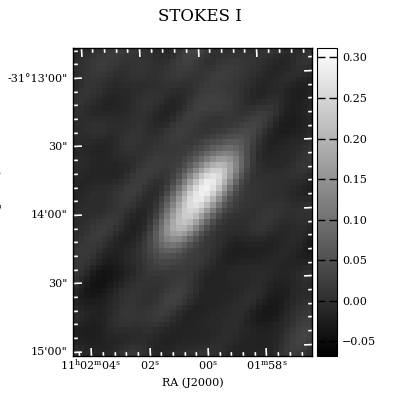

INFO: Auto-setting vmin to -6.791e-02 [aplpy.core]
INFO: Auto-setting vmax to  3.116e-01 [aplpy.core]


<IPython.core.display.Javascript object>


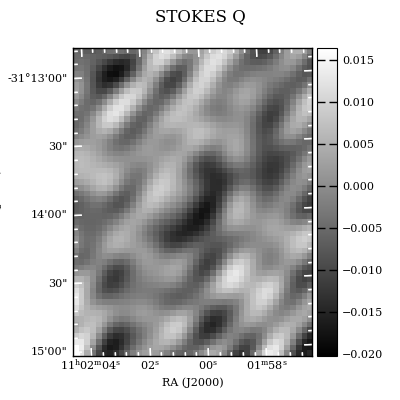

INFO: Auto-setting vmin to -2.027e-02 [aplpy.core]
INFO: Auto-setting vmax to  1.649e-02 [aplpy.core]


<IPython.core.display.Javascript object>


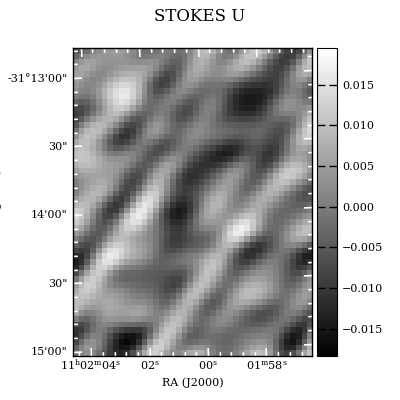

INFO: Auto-setting vmin to -1.835e-02 [aplpy.core]
INFO: Auto-setting vmax to  1.953e-02 [aplpy.core]


<IPython.core.display.Javascript object>


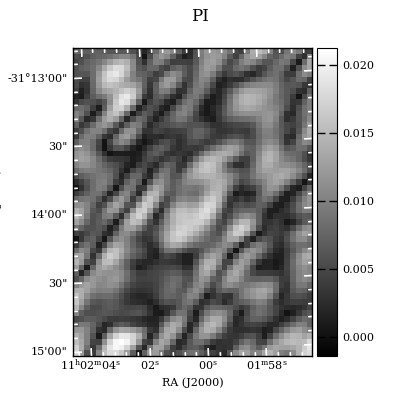

INFO: Auto-setting vmin to -1.361e-03 [aplpy.core]
INFO: Auto-setting vmax to  2.126e-02 [aplpy.core]
(28, 22)


<IPython.core.display.Javascript object>


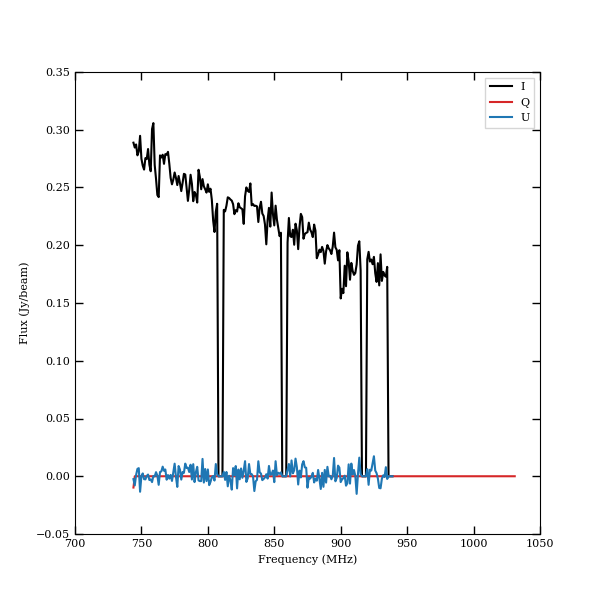

<IPython.core.display.Javascript object>


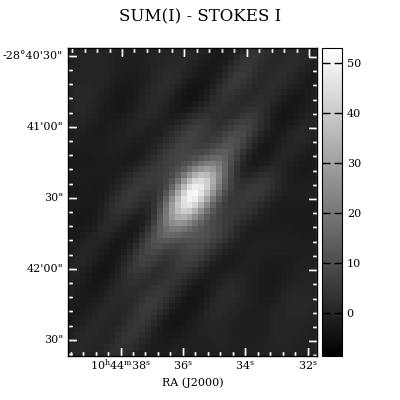

INFO: Auto-setting vmin to -8.600e+00 [aplpy.core]
INFO: Auto-setting vmax to  5.310e+01 [aplpy.core]


<IPython.core.display.Javascript object>


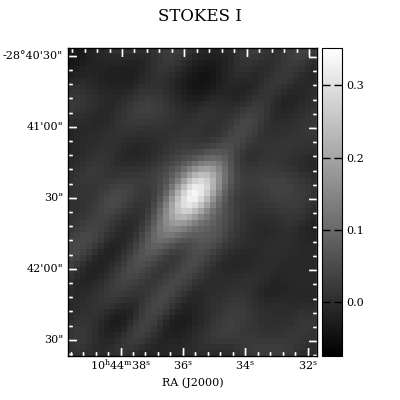

INFO: Auto-setting vmin to -7.445e-02 [aplpy.core]
INFO: Auto-setting vmax to  3.518e-01 [aplpy.core]


<IPython.core.display.Javascript object>


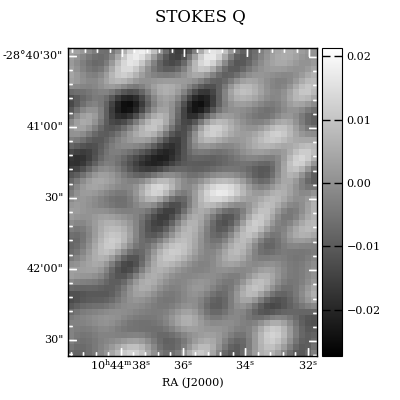

INFO: Auto-setting vmin to -2.734e-02 [aplpy.core]
INFO: Auto-setting vmax to  2.130e-02 [aplpy.core]


<IPython.core.display.Javascript object>


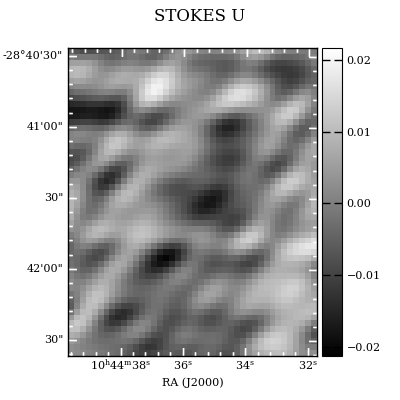

INFO: Auto-setting vmin to -2.132e-02 [aplpy.core]
INFO: Auto-setting vmax to  2.173e-02 [aplpy.core]


<IPython.core.display.Javascript object>


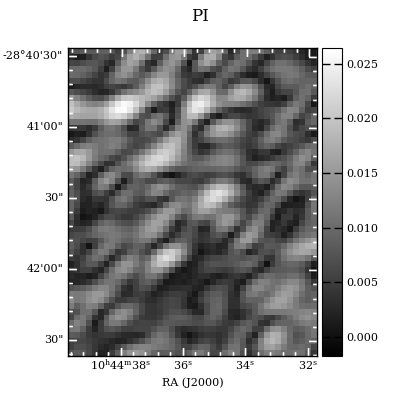

INFO: Auto-setting vmin to -1.740e-03 [aplpy.core]
INFO: Auto-setting vmax to  2.643e-02 [aplpy.core]
(27, 21)


<IPython.core.display.Javascript object>


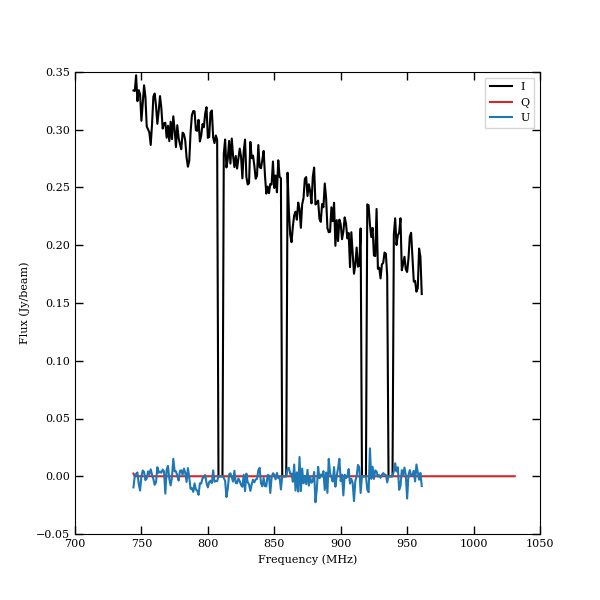

In [34]:
for i in range(10):
    makeplots(i)

# Farnes 2018 testing

In [3]:
def mu(arr):
    '''
    \mu moment - freq axis first
    '''
    n = arr.shape[0]
    mu = np.nansum(arr, axis=0)/n
    return mu

def sigma(arr, mu):
    n = arr.shape[0]
    sigma = np.sqrt((1/(n-1)) * np.nansum( (arr - mu)**2 , axis=0))
    return sigma

def psi(arr, mu):
    n = arr.shape[0]
    num = (1/n) * np.nansum( (arr - mu)**3 , axis=0)
    dem = ((1/(n-1)) * np.nansum( (arr - mu)**2 , axis=0))**(3/2)
    psi = num/dem
    return psi

def kappa(arr, mu):
    n = arr.shape[0]
    num = (1/n) * np.nansum( (arr - mu)**4, axis=0 )
    dem = ((1/(n-1)) * np.nansum( (arr - mu)**2, axis=0 ))**2
    kappa = num/dem - 3
    return kappa


<IPython.core.display.Javascript object>


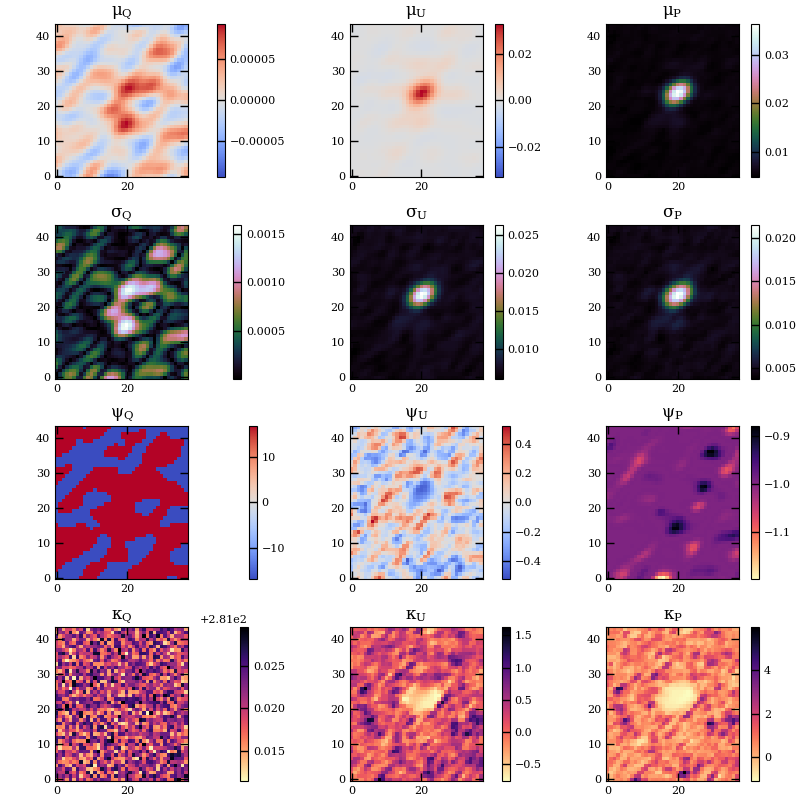

Text(0.5, 1.0, '$\\kappa_P$')

In [20]:
fig = plt.figure(constrained_layout=True, figsize=(8,8))
spec = fig.add_gridspec(ncols=3, nrows=4)
im = fig.add_subplot(spec[0,0]).imshow(mu_q, origin='lower', cmap='coolwarm', \
                                       vmin=-np.nanmax(abs(mu_q)), vmax =np.nanmax(abs(mu_q)))
plt.colorbar(im)
plt.title('$\mu_Q$')
im = fig.add_subplot(spec[0,1]).imshow(mu_u, origin='lower', cmap='coolwarm', \
                                       vmin=-np.nanmax(abs(mu_u)), vmax =np.nanmax(abs(mu_u)))
plt.colorbar(im)
plt.title('$\mu_U$')
im = fig.add_subplot(spec[0,2]).imshow(mu_p, origin='lower', cmap='cubehelix')
plt.colorbar(im)
plt.title('$\mu_P$')

im = fig.add_subplot(spec[1,0]).imshow(sigma_q, origin='lower', cmap='cubehelix')
plt.colorbar(im)
plt.title('$\sigma_Q$')
im = fig.add_subplot(spec[1,1]).imshow(sigma_u, origin='lower', cmap='cubehelix')
plt.colorbar(im)
plt.title('$\sigma_U$')
im = fig.add_subplot(spec[1,2]).imshow(sigma_p, origin='lower', cmap='cubehelix')
plt.colorbar(im)
plt.title('$\sigma_P$')

im = fig.add_subplot(spec[2,0]).imshow(psi_q, origin='lower', cmap='coolwarm', \
                                       vmin=-np.nanmax(abs(psi_q)), vmax =np.nanmax(abs(psi_q)))
plt.colorbar(im)
plt.title('$\psi_Q$')
im = fig.add_subplot(spec[2,1]).imshow(psi_u, origin='lower', cmap='coolwarm', \
                                       vmin=-np.nanmax(abs(psi_u)), vmax =np.nanmax(abs(psi_u)))
plt.colorbar(im)
plt.title('$\psi_U$')
im = fig.add_subplot(spec[2,2]).imshow(psi_p, origin='lower', cmap='magma_r')
plt.colorbar(im)
plt.title('$\psi_P$')

im = fig.add_subplot(spec[3,0]).imshow(kappa_q, origin='lower', cmap='magma_r')
plt.colorbar(im)
plt.title('$\kappa_Q$')
im = fig.add_subplot(spec[3,1]).imshow(kappa_u, origin='lower', cmap='magma_r')
plt.colorbar(im)
plt.title('$\kappa_U$')
im = fig.add_subplot(spec[3,2]).imshow(kappa_p, origin='lower', cmap='magma_r')
plt.colorbar(im)
plt.title('$\kappa_P$')
#fig.add_subplot(spec[0,0]).imshow(mu_q, origin='lower', cmap='coolwarm')
#fig.add_subplot(spec[0,1]).imshow(mu_u, origin='lower', cmap='coolwarm')
#fig.add_subplot(spec[0,2]).imshow(mu_p, origin='lower', cmap='cubehelix')
#f4_ax1 = fig4.add_subplot(spec4[0, 0])
#f4_ax1.annotate('GridSpec[0, 0]', **anno_opts)
#fig4.add_subplot(spec4[0, 1]).annotate('GridSpec[0, 1:]', **anno_opts)
#fig4.add_subplot(spec4[1, 0]).annotate('GridSpec[1:, 0]', **anno_opts)
#fig4.add_subplot(spec4[1, 1]).annotate('GridSpec[1:, 1:]', **anno_opts)

In [4]:
# Read data using Spectral cube
with fits.open(cubes[1], mode='denywrite') as hdulist:
    q_cube = hdulist[0].data
    head = hdulist[0].header
with fits.open(cubes[2], mode='denywrite') as hdulist:
    u_cube = hdulist[0].data

#p_cube = (q_cube**2 + u_cube**2)**0.5

In [85]:
mu_q = mu(np.squeeze(q_cube))
outfile = cubes[1].replace('contcube','mu')
fits.writeto(outfile, mu_q, header=head)

In [86]:
mu_u = mu(np.squeeze(u_cube))
outfile = cubes[2].replace('contcube','mu')
fits.writeto(outfile, mu_u, header=head)

In [111]:
sigma_q = sigma(np.squeeze(q_cube), mu_q)
outfile = cubes[1].replace('contcube','sigma')
fits.writeto(outfile, sigma_q, header=head)

In [112]:
sigma_u = sigma(np.squeeze(u_cube), mu_u)
outfile = cubes[2].replace('contcube','sigma')
fits.writeto(outfile, sigma_u, header=head)

In [5]:
p_cube = np.sqrt(np.squeeze(q_cube)**2 + np.squeeze(u_cube)**2)

In [6]:
mu_p = mu(p_cube)
outfile = cubes[1].replace('contcube','mu').replace('q','p')
fits.writeto(outfile, mu_p, header=head)

OSError: File '/avatar/athomson/cubes/8585/RACS_test4_1.05_1049-31A/image.restored.p.SB8583.mu.RACS_test4_1.05_1049-31A.linmos.fits' already exists.

In [7]:
sigma_p = sigma(p_cube, mu_p)
outfile = cubes[1].replace('contcube','sigma').replace('q','p')
fits.writeto(outfile, sigma_p, header=head)

MemoryError: Unable to allocate array with shape (288, 8720, 8719) and data type bool

<IPython.core.display.Javascript object>


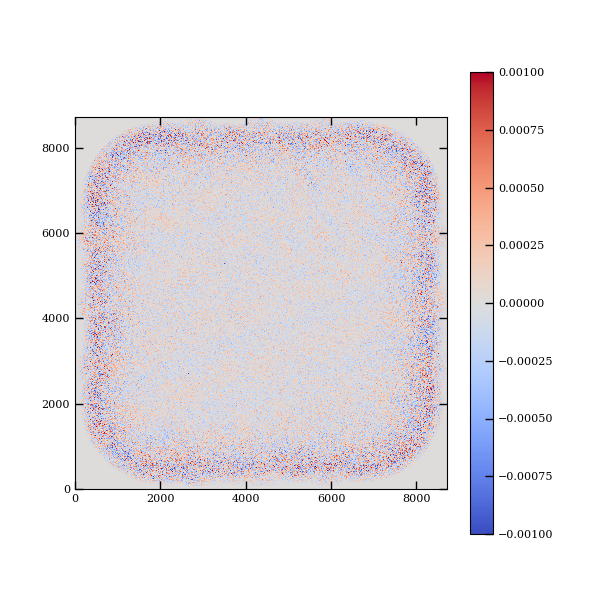

In [119]:
plt.figure()
plt.imshow(mu_u, origin='lower', cmap=plt.cm.coolwarm)
plt.colorbar()
lim = 1e-3
plt.clim(-lim, lim)

<IPython.core.display.Javascript object>


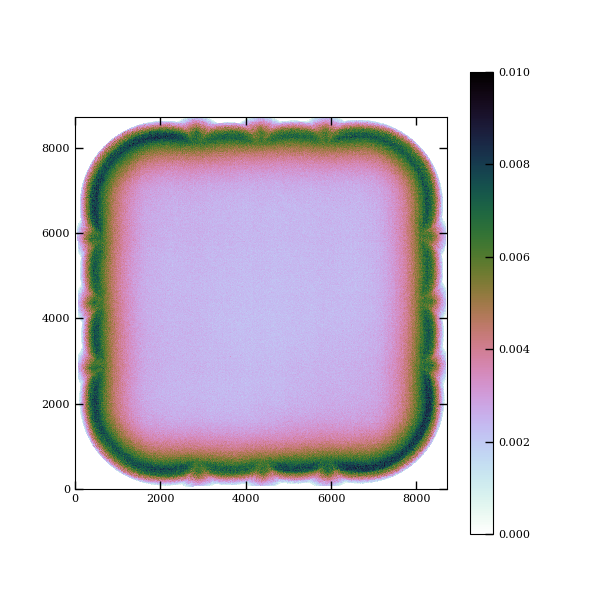

In [108]:
plt.figure()
plt.imshow(np.squeeze(sigma_u), origin='lower', cmap=plt.cm.cubehelix_r)
plt.colorbar()
plt.clim(0,0.01)